In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

safi = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/main/data/2023/2023-06-13/safi_data.csv")

In [ ]:
safi.columns

Index(['key_ID', 'village', 'interview_date', 'no_membrs', 'years_liv',
       'respondent_wall_type', 'rooms', 'memb_assoc', 'affect_conflicts',
       'liv_count', 'items_owned', 'no_meals', 'months_lack_food',
       'instanceID'],
      dtype='object')

In [ ]:
features = ["no_meals","months_lack_food","liv_count","rooms","n_items_owned"]

In [ ]:
safi["n_items_owned"] = safi["items_owned"].fillna("").str.split().str.len()

In [ ]:
#Scale + cluster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = safi[features].select_dtypes(include="number")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=0)
safi["cluster"] = kmeans.fit_predict(X_scaled)

safi["cluster"].value_counts()

,count
cluster,
1,74
2,49
0,8


Cluster 1 = majority (typical households)

Cluster 2 = second common group

Cluster 0 = very small group (special / extreme)

While the small cluster sizes may seem like a red flag, but the dataset is small too begin with so it may be okay.

In [ ]:
#Compare clusters vs village (village-level effect)
pd.crosstab(safi["cluster"], safi["village"])

village,Chirodzo,God,Ruaca
cluster,,,
0,2,2,4
1,23,22,29
2,14,19,16


villages are evenly distributed across clusters.
Village does NOT strongly determine outcomes.

<Axes: xlabel='cluster'>

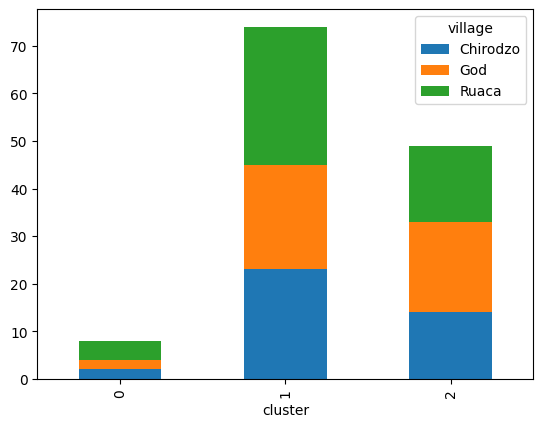

In [ ]:
pd.crosstab(safi["cluster"], safi["village"]).plot(kind="bar", stacked=True)

In [ ]:
#Compare clusters vs assets (household effect)
safi.groupby("cluster")[["liv_count","rooms","no_membrs","no_meals"]].mean()


,liv_count,rooms,no_membrs,no_meals
cluster,,,,
0,2.125000,4.750000,10.000000,2.625
1,2.459459,1.554054,7.162162,3.000
2,2.265306,1.530612,6.775510,2.000


assets/household resources DO vary by cluster

In [ ]:
safi.groupby("cluster")[["n_items_owned","liv_count","rooms"]].mean()

,n_items_owned,liv_count,rooms
cluster,,,
0,1.000000,2.125000,4.750000
1,0.932432,2.459459,1.554054
2,0.897959,2.265306,1.530612


In [ ]:
#Irrigation membership
pd.crosstab(safi["cluster"], safi["memb_assoc"])

memb_assoc,no,yes
cluster,,
0,4,1
1,34,21
2,21,11


Cluster 1

21 / 55 ≈ 38% yes

Cluster 2

11 / 32 ≈ 34% yes

Cluster 0

1 / 5 ≈ 20% yes (tiny group)
=> The percentages are very similar across clusters. Irrigation membership does NOT strongly explain cluster differences

<Axes: xlabel='cluster'>

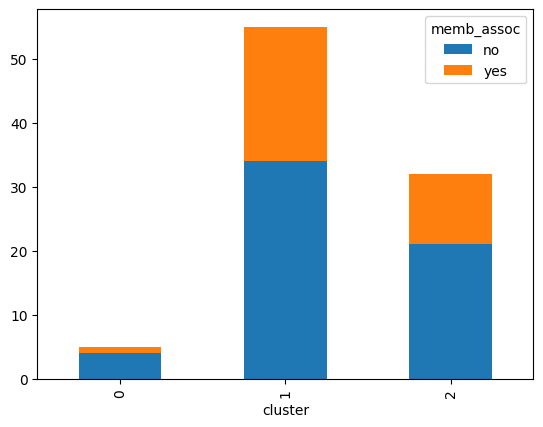

In [ ]:
pd.crosstab(safi["cluster"], safi["memb_assoc"]).plot(kind="bar", stacked=True)

In [ ]:
#Conflict exposure
pd.crosstab(safi["cluster"], safi["affect_conflicts"])

affect_conflicts,frequently,more_once,never,once
cluster,,,,
0,1,1,3,0
1,6,20,24,5
2,2,8,19,3


Conflict exposure is evenly distributed. Conflict does NOT strongly separate outcome groups

<Axes: xlabel='cluster'>

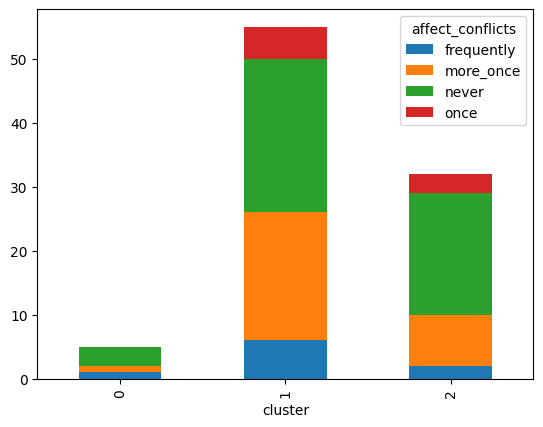

In [ ]:
pd.crosstab(safi["cluster"], safi["affect_conflicts"]).plot(kind="bar", stacked=True)

##hierarchical cluster

In [ ]:
from sklearn.preprocessing import StandardScaler

# Example: use the numeric features you clustered on
# (edit this list to match what you used)
features = ["no_membrs", "rooms", "liv_count", "no_meals", "months_lack_food", "number_items"]

X = safi[features].select_dtypes(include="number").copy()
X = X.fillna(X.median())

X_scaled = StandardScaler().fit_transform(X)

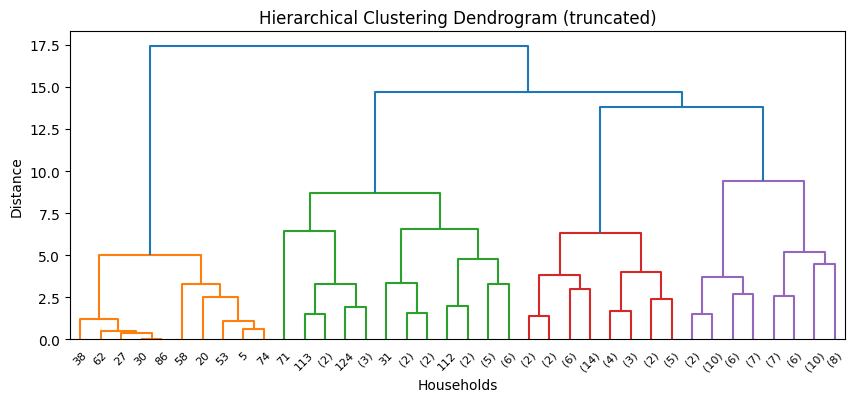

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

Z = linkage(X_scaled, method="ward")  # ward is common for continuous numeric data

plt.figure(figsize=(10, 4))
dendrogram(Z, truncate_mode="level", p=5)  # p controls how much you show
plt.title("Hierarchical Clustering Dendrogram (truncated)")
plt.xlabel("Households")
plt.ylabel("Distance")
plt.show()

In [ ]:
from scipy.cluster.hierarchy import fcluster

safi["hcluster"] = fcluster(Z, t=3, criterion="maxclust") - 1  # labels 0,1,2
safi["hcluster"].value_counts()

,count
hcluster,
2,94
1,27
0,10


In [ ]:
#Village
pd.crosstab(safi["hcluster"], safi["village"])

village,Chirodzo,God,Ruaca
hcluster,,,
0,3,4,3
1,8,5,14
2,28,34,32


In [ ]:
#Irrigation membership (memb_assoc)
pd.crosstab(safi["hcluster"], safi["memb_assoc"])

memb_assoc,no,yes
hcluster,,
0,4,0
1,13,10
2,42,23


In [ ]:
#Conflict exposure (affect_conflicts)
pd.crosstab(safi["hcluster"], safi["affect_conflicts"])

affect_conflicts,frequently,more_once,never,once
hcluster,,,,
0,0,1,3,0
1,4,5,14,0
2,5,23,29,8


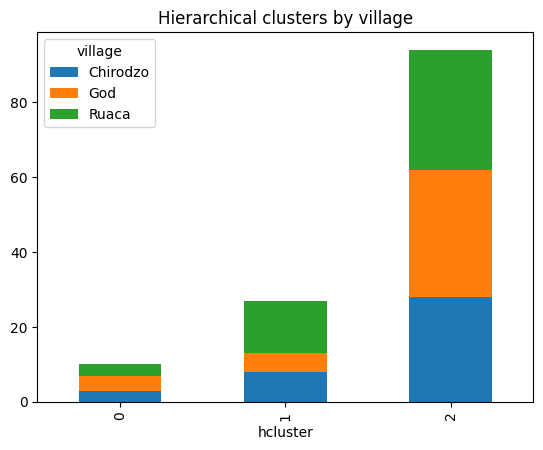

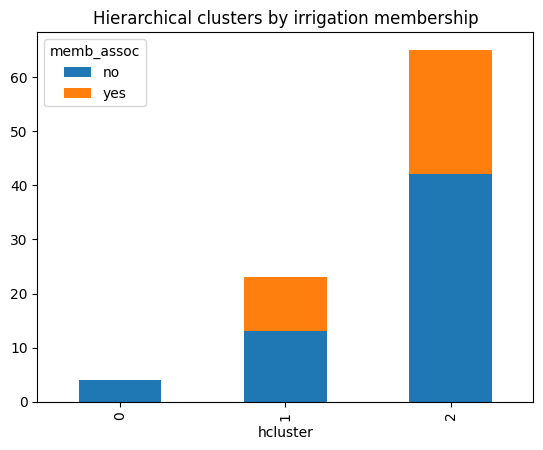

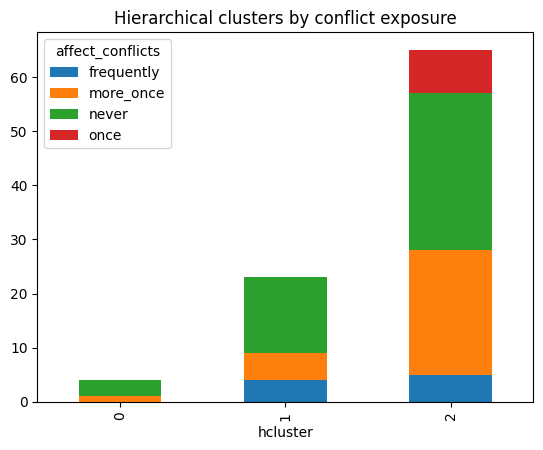

In [ ]:
#stacked bars
pd.crosstab(safi["hcluster"], safi["village"]).plot(kind="bar", stacked=True, title="Hierarchical clusters by village")
plt.show()

pd.crosstab(safi["hcluster"], safi["memb_assoc"]).plot(kind="bar", stacked=True, title="Hierarchical clusters by irrigation membership")
plt.show()

pd.crosstab(safi["hcluster"], safi["affect_conflicts"]).plot(kind="bar", stacked=True, title="Hierarchical clusters by conflict exposure")
plt.show()

In [ ]:
#4) Interpret cluster “profiles” (means by cluster)
num_features = safi[features].select_dtypes(include="number").columns.tolist()
safi.groupby("hcluster")[num_features].mean()

,no_membrs,rooms,liv_count,no_meals,number_items
hcluster,,,,,
0,4.300000,1.200000,1.400000,2.500000,0.0
1,11.370370,3.074074,2.851852,2.666667,1.0
2,6.297872,1.414894,2.329787,2.595745,1.0


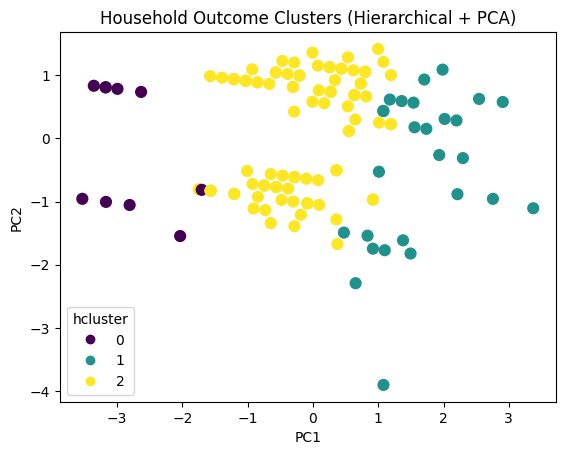

In [ ]:
from sklearn.decomposition import PCA

coords = PCA(n_components=2).fit_transform(X_scaled)

plt.figure()
sc = plt.scatter(coords[:,0], coords[:,1], c=safi["hcluster"], s=60)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("Household Outcome Clusters (Hierarchical + PCA)")
plt.legend(*sc.legend_elements(), title="hcluster")
plt.show()